In [1]:
import os
import glob
import time
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np


In [3]:
def get_deformation_elems(x, y, u, v, a):
    """ Compute deformation for given elements.

    Input X, Y, U, V are organized in three columns: for each node of M elements.
    To convert deformation rates from 1/s to %/day outputs should be multiplied by 8640000.

    Parameters
    ----------
    x : 3xM ndarray
        X-coordinates of nodes, m
    y : 3xM ndarray
        Y-coordinates of nodes, m
    u : 3xM ndarray
        U-component of nodes, m/s
    v : 3xM ndarray
        V-component of nodes, m/s
    a : Mx1 ndarray
        area of elements, m2

    Returns
    -------
    e1 : Mx1 array
        Divergence, 1/s
    e2 : Mx1 array
        Shear, 1/s
    e3 : Mx1 array
        Total deformation, 1/s

    """
    # contour integrals of u and v [m/s * m ==> m2/s]
    ux = uy = vx = vy = 0
    for i0, i1 in zip([1, 2, 0], [0, 1, 2]):
        ux += (u[i0] + u[i1]) * (y[i0] - y[i1])
        uy -= (u[i0] + u[i1]) * (x[i0] - x[i1])
        vx += (v[i0] + v[i1]) * (y[i0] - y[i1])
        vy -= (v[i0] + v[i1]) * (x[i0] - x[i1])
    # divide integral by double area [m2/s / m2 ==> 1/day]
    ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]

    # deformation components
    e1 = ux + vy
    e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
    e3 = np.hypot(e1, e2)

    return e1, e2, e3

def get_deformation_nodes(x, y, u, v):
    """ Compute deformation for given nodes.

    Input X, Y, U, V are given for individual N nodes. Nodes coordinates are triangulated and
    area, perimeter and deformation is computed for M elements.

    Parameters
    ----------
    x : Nx1 ndarray
        X-coordinates of nodes, m
    y : Nx1 ndarray
        Y-coordinates of nodes, m
    u : Nx1 ndarray
        U-component of nodes, m/s
    v : Nx1 ndarray
        V-component of nodes, m/s

    Returns
    -------
    e1 : Mx1 array
        Divergence, 1/s
    e2 : Mx1 array
        Shear, 1/s
    e3 : Mx1 array
        Total deformation, 1/s
    a : Mx1 array
        Area, m2
    p : Mx1 array
        Perimeter, m
    t : 3xM array
        Triangulation (indices of input nodes for each element)

    """
    tri = Triangulation(x, y)

    # coordinates and speeds of corners of each element
    xt, yt, ut, vt = [i[tri.triangles].T for i in (x, y, u, v)]

    # side lengths (X,Y,tot)
    tri_x = np.diff(np.vstack([xt, xt[0]]), axis=0)
    tri_y = np.diff(np.vstack([yt, yt[0]]), axis=0)
    tri_s = np.hypot(tri_x, tri_y)
    # perimeter
    tri_p = np.sum(tri_s, axis=0)
    s = tri_p/2
    # area
    tri_a = np.sqrt(s * (s - tri_s[0]) * (s - tri_s[1]) * (s - tri_s[2]))

    # deformation components
    e1, e2, e3 = get_deformation_elems(xt, yt, ut, vt, tri_a)

    return e1, e2, e3, tri_a, tri_p, tri.triangles

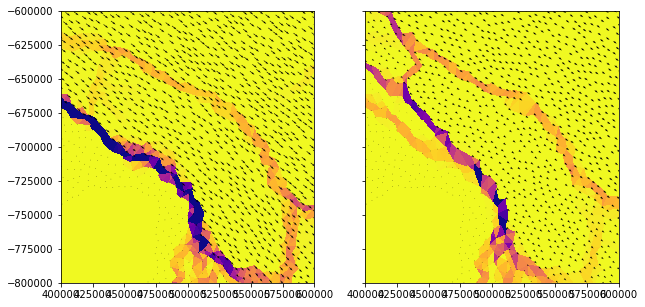

In [4]:
odir = '/data1/antonk/harmony'

n1 = np.load(os.path.join(odir, 'field_20190101T000000Z.npz'))
n2 = np.load(os.path.join(odir, 'field_20190101T000000Z_vel.npz'))
xlim = [400000, 600000]
ylim = [-800000, -600000]

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
for i, n in enumerate([n1, n2]):
    e1, e2, e3, a, p, t = get_deformation_nodes(n['x'], n['y'], n['u'], n['v'])
    ax[i].tripcolor(n['x'], n['y'], e3*24*60*60, triangles=t, vmin=0, vmax=2, cmap='plasma_r')
    q = ax[i].quiver(n['x'], n['y'], n['u'], n['v'], angles='xy', scale=10)
    ax[i].quiverkey(q, X=0.3, Y=1.1, U=1, label='Drift: 1 m/s', labelpos='E')
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
plt.show()


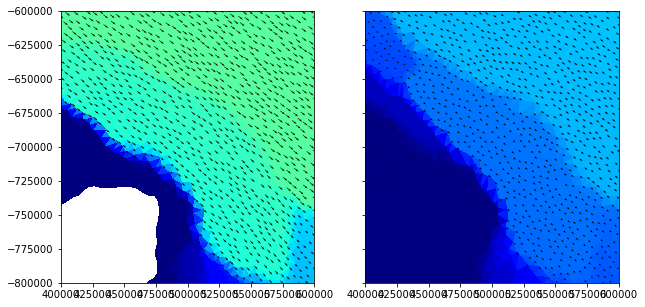

In [12]:
xlim = [400000, 600000]
ylim = [-800000, -600000]

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
for i, n in enumerate([n1, n2]):
    u_elems = n['u'][n['i']]
    v_elems = n['v'][n['i']]
    u_avg = u_elems.mean(axis=1)
    v_avg = v_elems.mean(axis=1)
    spd = np.hypot(u_avg, v_avg)

    ax[i].tripcolor(n['x'], n['y'], spd, triangles=n['i'], vmin=0, vmax=0.5, cmap='jet')
    q = ax[i].quiver(n['x'], n['y'], n['u'], n['v'], angles='xy', scale=10)
    ax[i].quiverkey(q, X=0.3, Y=1.1, U=1, label='Drift: 1 m/s', labelpos='E')
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
plt.show()